In [123]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
import random
from sklearn.base import BaseEstimator, TransformerMixin


# Define the Autoencoder model.
class AutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        """
        Autoencoder with configurable latent space dimensionality.
        """
        super(AutoEncoder, self).__init__()
        # Encoder: input -> hidden -> latent
        self.encoder = nn.Sequential(nn.Linear(input_dim, 128), nn.ReLU(), nn.Linear(128, latent_dim))
        # Decoder: latent -> hidden -> reconstruction of input
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 128), nn.ReLU(), nn.Linear(128, input_dim))

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, z


def compute_dominance_penalty(x, z, margin=0.1):
    """
    Computes the pairwise dominance penalty.

    For every pair (i, j) in the batch, if sample i dominates sample j in the input space
    (i.e., all features of x[i] are >= corresponding features of x[j] with at least one strictly greater),
    then add a hinge loss term to ensure that z[i] is at least `margin` higher than z[j] for each latent dimension.

    The hinge loss per latent dimension is:
        loss = max(0, z[j] - z[i] + margin)
    """
    penalty = 0.0
    batch_size = x.size(0)
    # Loop over all pairs in the batch
    for i in range(batch_size):
        for j in range(batch_size):
            if i == j:
                continue
            # Check dominance: sample i dominates sample j.
            if torch.all(x[i] >= x[j]) and torch.any(x[i] > x[j]):
                diff = z[j] - z[i] + margin
                penalty += F.relu(diff).sum()
    return penalty


class DominanceAutoEncoder(BaseEstimator, TransformerMixin):
    """
    An sklearn-like autoencoder that accepts a pandas DataFrame,
    trains with a dominance penalty, and provides a fit_transform method.

    This implementation includes:
      - A random_state parameter to set seeds in the fit() method.
      - A verbose mode to print training loss.
      - Compatibility with sklearn's Pipeline.
    """

    def __init__(
        self,
        latent_dim=2,
        num_epochs=10,
        lambda_rank=1.0,
        margin=0.1,
        lr=1e-3,
        batch_size=32,
        random_state=None,
        device=None,
        verbose=False,
    ):
        self.latent_dim = latent_dim
        self.num_epochs = num_epochs
        self.lambda_rank = lambda_rank
        self.margin = margin
        self.lr = lr
        self.batch_size = batch_size
        self.random_state = random_state
        self.device = device
        self.verbose = verbose

        self.model = None
        self.input_dim = None

    def _set_random_seed(self):
        if self.random_state is not None:
            np.random.seed(self.random_state)
            random.seed(self.random_state)
            torch.manual_seed(self.random_state)
            if self.device is None:
                self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            else:
                self.device = torch.device(self.device)
            if self.device.type == "cuda":
                torch.cuda.manual_seed_all(self.random_state)
                torch.backends.cudnn.deterministic = True
                torch.backends.cudnn.benchmark = False

    def _build_model(self, input_dim):
        self.input_dim = input_dim
        self.model = AutoEncoder(input_dim=input_dim, latent_dim=self.latent_dim).to(self.device)

    def fit(self, X, y=None):
        """
        Fit the autoencoder on a pandas DataFrame X.

        Parameters:
            X (numpy array): Input data.
            y: Ignored, exists for compatibility with sklearn's Pipeline.

        Returns:
            self
        """
        # Set random seeds for reproducibility.
        self._set_random_seed()

        # Convert DataFrame to tensor (float32) and build DataLoader.
        X_np = X.astype(np.float32)
        dataset = TensorDataset(torch.from_numpy(X_np))
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        if self.input_dim is None:
            self._build_model(input_dim=X_np.shape[1])

        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        mse_loss = nn.MSELoss()

        self.model.train()
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            for batch in dataloader:
                x = batch[0].to(self.device)
                optimizer.zero_grad()
                x_hat, z = self.model(x)
                loss_recon = mse_loss(x_hat, x)
                loss_dom = compute_dominance_penalty(x, z, margin=self.margin)
                loss = loss_recon + self.lambda_rank * loss_dom
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            avg_loss = epoch_loss / len(dataloader)
            if avg_loss < 0.001:
                break
            if self.verbose:
                print(f"Epoch {epoch + 1}/{self.num_epochs}, Loss: {avg_loss:.4f}")
        return self

    def transform(self, X):
        """
        Transforms the input DataFrame X into the latent space.

        Parameters:
            X (pandas.DataFrame): Input data.

        Returns:
            numpy.ndarray: The latent representations.
        """
        self.model.eval()
        X_np = X.astype(np.float32)
        X_tensor = torch.from_numpy(X_np).to(self.device)
        with torch.no_grad():
            _, z = self.model(X_tensor)
        return z.cpu().numpy()

    def fit_transform(self, X, y=None):
        """
        Fit the model on X and return the latent representations.

        Parameters:
            X (pandas.DataFrame): Input data.
            y: Ignored, exists for compatibility.

        Returns:
            numpy.ndarray: The latent representations.
        """
        self.fit(X, y)
        return self.transform(X)

    def get_params(self, deep=True):
        """
        Return parameters for this estimator.
        """
        return {
            "latent_dim": self.latent_dim,
            "num_epochs": self.num_epochs,
            "lambda_rank": self.lambda_rank,
            "margin": self.margin,
            "lr": self.lr,
            "batch_size": self.batch_size,
            "random_state": self.random_state,
            "device": self.device,
            "verbose": self.verbose,
        }

    def set_params(self, **params):
        """
        Set the parameters of this estimator.
        """
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [124]:
from collections import defaultdict

import pandas as pd
import numpy as np
from umap import UMAP
from sklearn.decomposition import NMF, PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap, SpectralEmbedding, LocallyLinearEmbedding
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.pipeline import Pipeline

from mcda.dataset import MCDADataset
from methods.mvu import MaximumVarianceUnfolding

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

In [129]:
df = MCDADataset.read_csv("./data/countries-resilieance/dataset.csv").data

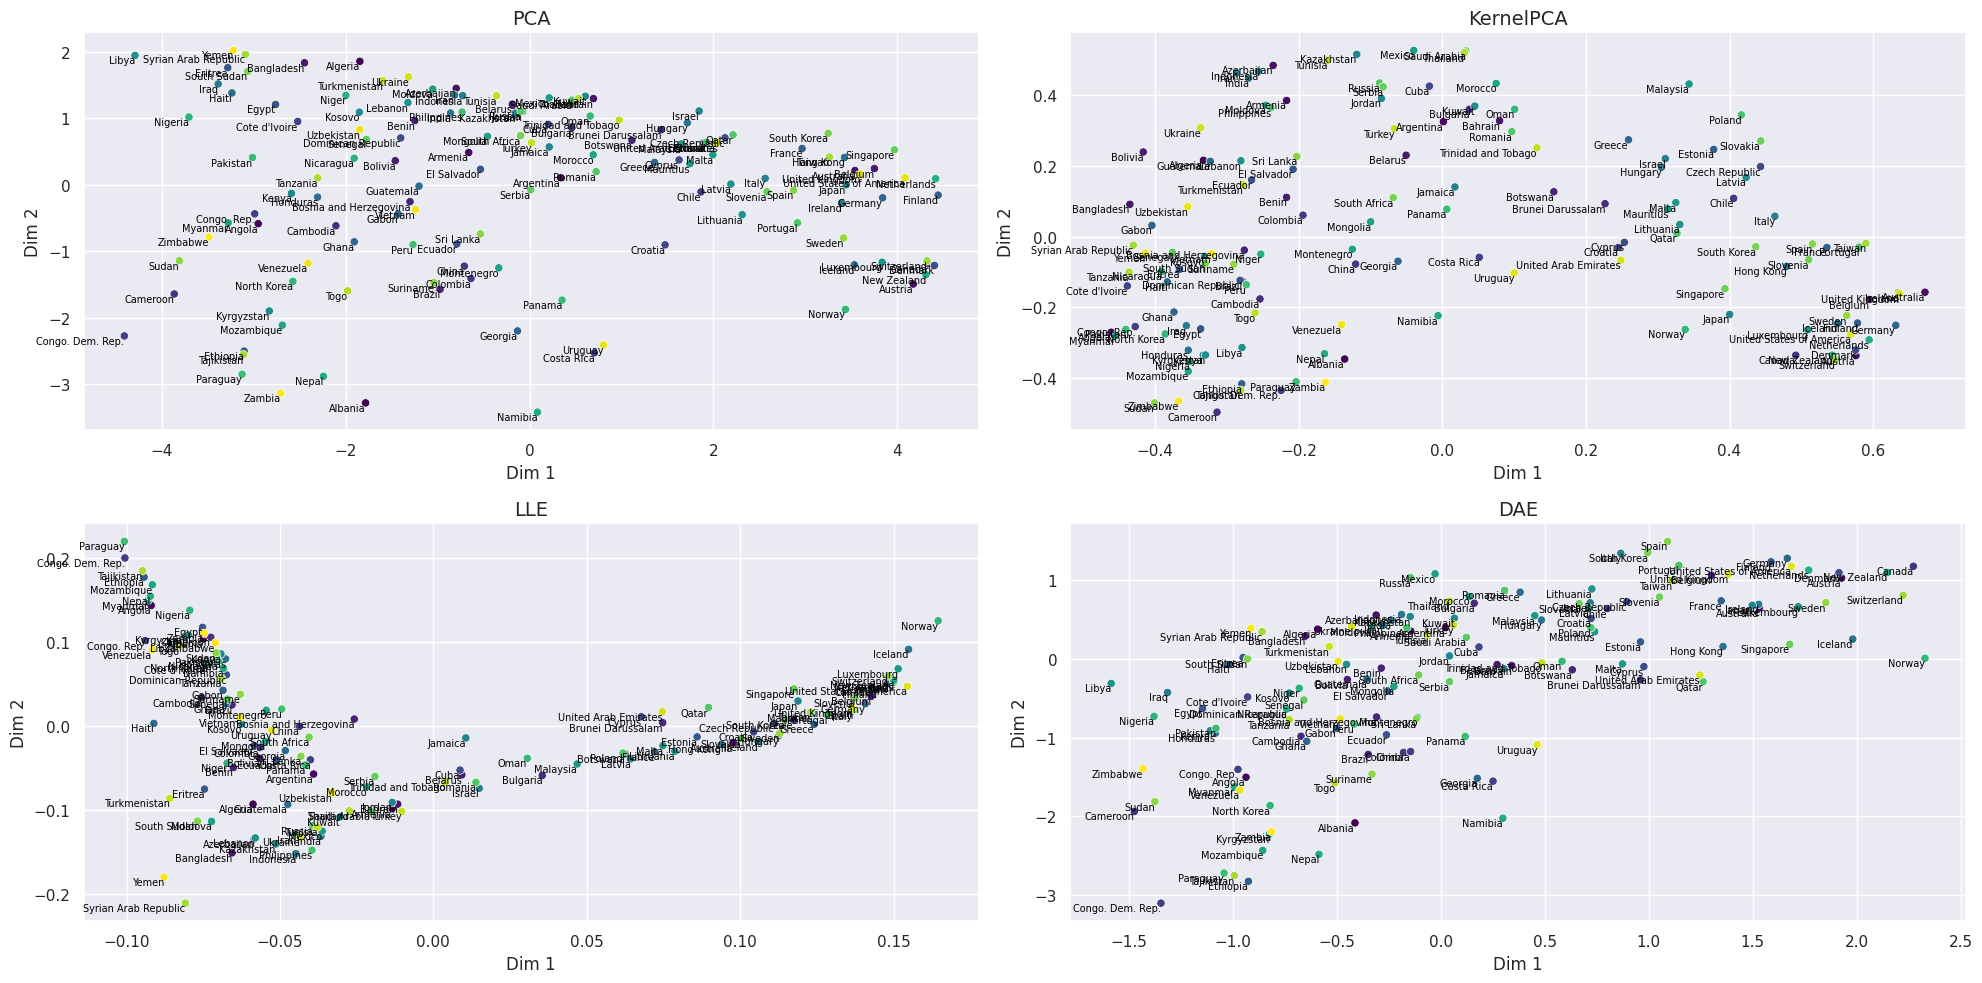

In [130]:
methods = {
    "PCA": Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=2, random_state=42))]),
    "KernelPCA": Pipeline(
        [("scaler", StandardScaler()), ("kpca", KernelPCA(n_components=2, kernel="rbf", random_state=42))]
    ),
    "LLE": Pipeline([("scaler", StandardScaler()), ("lle", LocallyLinearEmbedding(n_components=2, random_state=42))]),
    # "Isomap": Pipeline([("scaler", StandardScaler()), ("isomap", Isomap(n_components=2))]),
    # "MVU": Pipeline([("scaler", StandardScaler()), ("mvu", MaximumVarianceUnfolding(n_components=2, seed=42))]),
    "DAE": Pipeline(
        [
            ("scaler", StandardScaler()),
            ("dae", DominanceAutoEncoder(latent_dim=2, num_epochs=300, random_state=42, verbose=False)),
        ]
    ),
}

color = np.linspace(0, 1, df.shape[0])
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()

for i, (method_name, method) in enumerate(methods.items()):
    df_m = pd.DataFrame(method.fit_transform(df), index=df.index, columns=["Dim 1", "Dim 2"])
    sns.scatterplot(
        x="Dim 1",
        y="Dim 2",
        hue=color,
        palette="viridis",
        data=df_m,
        ax=axes[i],
        legend=False,
    )
    for j in range(df_m.shape[0]):
        axes[i].text(
            df_m.iloc[j, 0],
            df_m.iloc[j, 1],
            str(df_m.index[j]),
            fontsize=7,
            color="black",
            ha="right",
            va="top",
        )
    axes[i].set_title(f"{method_name}", fontsize=14)
    axes[i].set_xlabel("Dim 1")
    axes[i].set_ylabel("Dim 2")

plt.tight_layout()
plt.show()

In [131]:
def is_dominating(a_values, b_values) -> bool:
    return all(a >= b for a, b in zip(a_values, b_values)) and any(a > b for a, b in zip(a_values, b_values))


domination_org = []
for alt_1 in df.index:
    for alt_2 in df.index:
        if alt_1 == alt_2:
            continue

        if is_dominating(df.loc[alt_1, :].tolist(), df.loc[alt_2, :].tolist()):
            print(alt_1, " > ", alt_2)
            domination_org.append((alt_1, alt_2))

print(f"Oryginalnie wszystkich dominacji: {len(domination_org)}")

methods = {
    "PCA": Pipeline([("scaler", StandardScaler()), ("pca", PCA(n_components=2, random_state=42))]),
    "KernelPCA": Pipeline(
        [("scaler", StandardScaler()), ("kpca", KernelPCA(n_components=2, kernel="rbf", random_state=42))]
    ),
    "LLE": Pipeline([("scaler", StandardScaler()), ("lle", LocallyLinearEmbedding(n_components=2, random_state=42))]),
    "Isomap": Pipeline([("scaler", StandardScaler()), ("isomap", Isomap(n_components=2))]),
    # "MVU": Pipeline([("scaler", StandardScaler()), ("mvu", MaximumVarianceUnfolding(n_components=2, seed=42))]),
    "DEA": Pipeline(
        [
            ("scaler", StandardScaler()),
            ("dae", DominanceAutoEncoder(latent_dim=2, num_epochs=1000, random_state=42, verbose=False)),
        ]
    ),
}


N = 2

for method_name, method in methods.items():
    df_m = pd.DataFrame(method.fit_transform(df), index=df.index, columns=[f"Dim {i + 1}" for i in range(N)])
    counter = 0
    for alt_1, alt_2 in domination_org:
        if not is_dominating(df_m.loc[alt_1, :].tolist(), df_m.loc[alt_2, :].tolist()):
            # print("!!!", alt_1, " > ", alt_2)
            counter += 1
    print(f"{method_name.ljust(12, ' ')}niespełnionych dominacji: {counter}")

Argentina  >  Togo
Armenia  >  Congo. Dem. Rep.
Armenia  >  Kyrgyzstan
Armenia  >  Myanmar
Armenia  >  Tanzania
Australia  >  Albania
Australia  >  China
Australia  >  Gabon
Australia  >  Georgia
Australia  >  Nepal
Australia  >  Togo
Austria  >  Nepal
Belgium  >  Cambodia
Belgium  >  Togo
Bulgaria  >  Cameroon
Bulgaria  >  El Salvador
Bulgaria  >  Honduras
Bulgaria  >  Nicaragua
Bulgaria  >  Nigeria
Bulgaria  >  Pakistan
Bulgaria  >  Peru
Bulgaria  >  Sudan
Bulgaria  >  Zimbabwe
Canada  >  Albania
Canada  >  Brazil
Canada  >  Cameroon
Canada  >  Colombia
Canada  >  Congo. Dem. Rep.
Canada  >  Croatia
Canada  >  Ethiopia
Canada  >  Georgia
Canada  >  Kyrgyzstan
Canada  >  Nepal
Canada  >  North Korea
Canada  >  Panama
Canada  >  Sudan
Canada  >  Togo
Canada  >  Zambia
Congo. Rep.  >  Congo. Dem. Rep.
Costa Rica  >  Nepal
Costa Rica  >  Zambia
Cuba  >  Benin
Cuba  >  Eritrea
Cuba  >  Nepal
Cuba  >  South Sudan
Cuba  >  Zambia
Czech Republic  >  Albania
Czech Republic  >  Angola
Czech Re

Epoch 1/1000, Loss: 1.4461
Epoch 2/1000, Loss: 1.1964
Epoch 3/1000, Loss: 1.0883
Epoch 4/1000, Loss: 1.0587
Epoch 5/1000, Loss: 1.0343
Epoch 6/1000, Loss: 1.0131
Epoch 7/1000, Loss: 0.9910
Epoch 8/1000, Loss: 0.9683
Epoch 9/1000, Loss: 0.9452
Epoch 10/1000, Loss: 0.9213
Epoch 11/1000, Loss: 0.8962
Epoch 12/1000, Loss: 0.8705
Epoch 13/1000, Loss: 0.8439
Epoch 14/1000, Loss: 0.8165
Epoch 15/1000, Loss: 0.7893
Epoch 16/1000, Loss: 0.7631
Epoch 17/1000, Loss: 0.7362
Epoch 18/1000, Loss: 0.7085
Epoch 19/1000, Loss: 0.6805
Epoch 20/1000, Loss: 0.6520
Epoch 21/1000, Loss: 0.6231
Epoch 22/1000, Loss: 0.5940
Epoch 23/1000, Loss: 0.5647
Epoch 24/1000, Loss: 0.5358
Epoch 25/1000, Loss: 0.5076
Epoch 26/1000, Loss: 0.4804
Epoch 27/1000, Loss: 0.4544
Epoch 28/1000, Loss: 0.4297
Epoch 29/1000, Loss: 0.4064
Epoch 30/1000, Loss: 0.3850
Epoch 31/1000, Loss: 0.3655
Epoch 32/1000, Loss: 0.3483
Epoch 33/1000, Loss: 0.3333
Epoch 34/1000, Loss: 0.3207
Epoch 35/1000, Loss: 0.3107
Epoch 36/1000, Loss: 0.3031
E

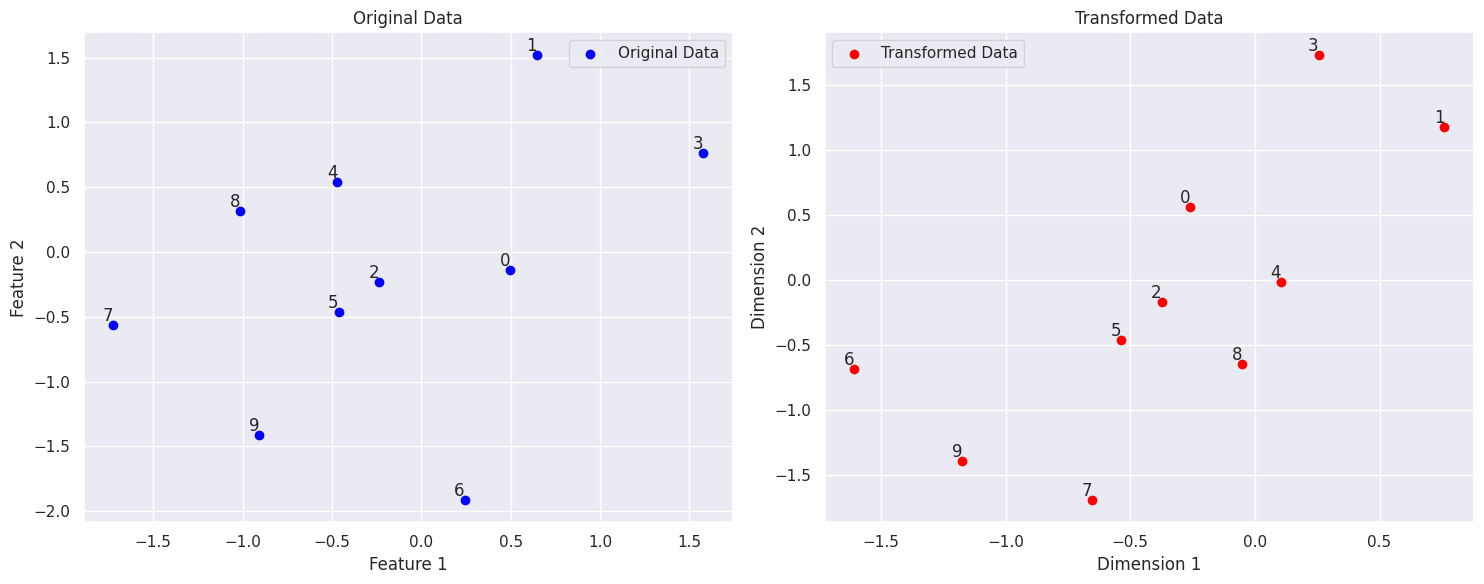

In [128]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

np.random.seed(42)
data = np.random.randn(10, 2)

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("dae", DominanceAutoEncoder(latent_dim=2, num_epochs=1000, random_state=42, verbose=True)),
    ]
)
transformed_data = pipe.fit_transform(data)


plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
plt.scatter(data[:, 0], data[:, 1], color="blue", label="Original Data")
for i, (x, y) in enumerate(data):
    plt.text(x, y, str(i), fontsize=12, ha="right", va="bottom")


plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Original Data")
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(transformed_data[:, 0], transformed_data[:, 1], color="red", label="Transformed Data")
for i, (x, y) in enumerate(transformed_data):
    plt.text(x, y, str(i), fontsize=12, ha="right", va="bottom")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.title("Transformed Data")
plt.legend()

plt.tight_layout()
plt.show()